## Read NZX50 Stocks File and Import Packages

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
from package import my_functions
warnings.filterwarnings('ignore')

url = 'https://www.interest.co.nz/nzx50'
nzx50 = pd.read_html(url,  flavor='html5lib')[0]

## Grab symbols from dataframe and convert into a list for YFinance

In [2]:
symbols_list = nzx50["Profile"].unique().tolist()
del symbols_list[-1]
symbols_list_nz = [symbol + ".NZ" for symbol in symbols_list]
symbols_list_nz = [s.replace('FHP.NZ', 'FPH.NZ') for s in symbols_list_nz] # had to change ticker to match yfinance ticker for FHP

In [3]:
end_date = '2024-03-10'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*2) # use last 2 years of data

df = yf.download(tickers=symbols_list_nz,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker'] # convert into multiindex df

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  50 of 50 completed


Price              adj close      close       high        low       open  \
date       ticker                                                          
2022-03-11 AIA.NZ   7.044579   7.140000   7.200000   7.090000   7.120000   
           AIR.NZ   0.774377   0.863834   0.885276   0.845454   0.876086   
           ANZ.NZ  24.075434  27.381542  27.609722  27.123602  27.480753   
           ARG.NZ   1.225725   1.390000   1.405000   1.375000   1.390000   
           ARV.NZ   1.433682   1.540000   1.570000   1.530000   1.570000   
...                      ...        ...        ...        ...        ...   
2024-03-08 VGL.NZ   1.680000   1.680000   1.680000   1.620000   1.620000   
           VHP.NZ   2.130000   2.130000   2.140000   2.115000   2.140000   
           VSL.NZ   8.270000   8.270000   8.440000   8.250000   8.250000   
           WBC.NZ  29.600000  29.600000  29.610001  28.700001  28.700001   
           WHS.NZ   1.258064   1.300000   1.320000   1.300000   1.320000   

Price               volume  
date       ticker           
2022-03-11 AIA.NZ  1025995  
           AIR.NZ  3634730  
           ANZ.NZ    25139  
           ARG.NZ   252586  
           ARV.NZ   267235  
...                    ...  
2024-03-08 VGL.NZ   137018  
           VHP.NZ   129645  
           VSL.NZ     7107  
           WBC.NZ    95334  
           WHS.NZ    29746  

[24900 rows x 6 columns]

In [4]:
index_names = df.index.names
column_names = df.columns.names

print("Index Names:", index_names)
print("Column Names:", column_names)

Index Names: ['date', 'ticker']
Column Names: ['Price']


In [5]:
columns = df.columns
print(columns)

Index(['adj close', 'close', 'high', 'low', 'open', 'volume'], dtype='object', name='Price')


## 2. Calculate Features and Technical indicators for each stock
* Garman - Klass Volatility is a volatility estimator that incorporates low, high, and close prices of a security
* RSI - Relative Strength Index measures that speed and magnitude of a security's recent price change
* Bollinger Bands - Helps determine whether prices are high or low on a relative basis
* ATR - Average True Range, price volatility indicator showing the average price variation of assets within a given time period
* MACD - Moving average convergence/divergence is a techical indicator to identify market entry points for buying/selling
* Dollar volume - number of shares traded times the price of the share

$$
    \text{Garman-Klass Volatilty} = \frac{(\text{ln}(\text{High})-\text{ln}(\text{Low}))^2}{2} - (2\text{ln}(2) -1)(\text{ln}(\text{Adj Close}) - \text{ln}(\text{Open}))^2
$$

In [6]:
my_functions.garman_klass_vol(df, "high", "low", "adj close", "open")
my_functions.rsi(df, "adj close")
my_functions.bollinger_bands(df, "adj close")
my_functions.compute_atr(df, 'high', 'low', 'close')
df['atr1'] = df.groupby(level=1, group_keys=False).apply(
    lambda group: my_functions.compute_atr(group, 'high', 'low', 'close')
)
df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(my_functions.compute_macd)
my_functions.dollar_volume(df, 'adj close', 'volume')

In [7]:
df

Price              adj close      close       high        low       open  \
date       ticker                                                          
2022-03-11 AIA.NZ   7.044579   7.140000   7.200000   7.090000   7.120000   
           AIR.NZ   0.774377   0.863834   0.885276   0.845454   0.876086   
           ANZ.NZ  24.075434  27.381542  27.609722  27.123602  27.480753   
           ARG.NZ   1.225725   1.390000   1.405000   1.375000   1.390000   
           ARV.NZ   1.433682   1.540000   1.570000   1.530000   1.570000   
...                      ...        ...        ...        ...        ...   
2024-03-08 VGL.NZ   1.680000   1.680000   1.680000   1.620000   1.620000   
           VHP.NZ   2.130000   2.130000   2.140000   2.115000   2.140000   
           VSL.NZ   8.270000   8.270000   8.440000   8.250000   8.250000   
           WBC.NZ  29.600000  29.600000  29.610001  28.700001  28.700001   
           WHS.NZ   1.258064   1.300000   1.320000   1.300000   1.320000   

Price               volume  garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                             
2022-03-11 AIA.NZ  1025995          0.000075        NaN       NaN       NaN   
           AIR.NZ  3634730         -0.004824        NaN       NaN       NaN   
           ANZ.NZ    25139         -0.006603        NaN       NaN       NaN   
           ARG.NZ   252586         -0.005878        NaN       NaN       NaN   
           ARV.NZ   267235         -0.002854        NaN       NaN       NaN   
...                    ...               ...        ...       ...       ...   
2024-03-08 VGL.NZ   137018          0.000150  57.467567  0.929810  0.959052   
           VHP.NZ   129645          0.000061  51.622335  1.105560  1.133823   
           VSL.NZ     7107          0.000257  58.741618  2.132727  2.185009   
           WBC.NZ    95334          0.000119  80.937582  3.269012  3.346795   
           WHS.NZ    29746         -0.000776  36.544815  0.796603  0.830936   

Price               bb_high      atr1      macd  dollar_volume  
date       ticker                                               
2022-03-11 AIA.NZ       NaN       NaN       NaN       7.227702  
           AIR.NZ       NaN       NaN       NaN       2.814650  
           ANZ.NZ       NaN       NaN       NaN       0.605232  
           ARG.NZ       NaN       NaN       NaN       0.309601  
           ARV.NZ       NaN       NaN       NaN       0.383130  
...                     ...       ...       ...            ...  
2024-03-08 VGL.NZ  0.988294  0.087438  0.423001       0.230190  
           VHP.NZ  1.162086 -0.425570 -0.138494       0.276144  
           VSL.NZ  2.237292 -0.276156  0.855618       0.058775  
           WBC.NZ  3.424578  1.488052  2.600949       2.821886  
           WHS.NZ  0.865269 -0.297073 -0.725573       0.037422  

[24900 rows x 14 columns]

## 3. Agregate to monthly level on technical indicators 
* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency

In [8]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]


data = pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                                                          df.unstack()[last_cols].resample('M').last().stack('ticker')], axis=1).dropna() 

data

dollar_volume  adj close  garman_klass_vol        rsi  \
date       ticker                                                          
2022-04-30 AIA.NZ       9.525962   7.730290          0.000184  58.188537   
           AIR.NZ       4.291557   0.793351         -0.004005  53.816039   
           ANZ.NZ       0.506043  26.038103         -0.005742  54.349625   
           ARG.NZ       0.510359   1.164691         -0.005703  37.897958   
           ARV.NZ       0.787794   1.526778         -0.000787  49.393827   
...                          ...        ...               ...        ...   
2024-03-31 VGL.NZ       0.794222   1.680000          0.000150  57.467567   
           VHP.NZ       0.491593   2.130000          0.000061  51.622335   
           VSL.NZ       0.056488   8.270000          0.000257  58.741618   
           WBC.NZ       1.255420  29.600000          0.000119  80.937582   
           WHS.NZ       0.191757   1.258064         -0.000776  36.544815   

                     bb_low    bb_mid   bb_high      atr1      macd  
date       ticker                                                    
2022-04-30 AIA.NZ  2.133144  2.155457  2.177769  0.760492  0.631985  
           AIR.NZ  0.525439  0.568056  0.610673  2.587225  0.588923  
           ANZ.NZ  3.274660  3.300577  3.326494 -0.265739  0.275524  
           ARG.NZ  0.770475  0.793023  0.815571  0.963290 -0.977687  
           ARV.NZ  0.915821  0.945272  0.974724  0.578546  0.488125  
...                     ...       ...       ...       ...       ...  
2024-03-31 VGL.NZ  0.929810  0.959052  0.988294  0.087438  0.423001  
           VHP.NZ  1.105560  1.133823  1.162086 -0.425570 -0.138494  
           VSL.NZ  2.132727  2.185009  2.237292 -0.276156  0.855618  
           WBC.NZ  3.269012  3.346795  3.424578  1.488052  2.600949  
           WHS.NZ  0.796603  0.830936  0.865269 -0.297073 -0.725573  

[1200 rows x 9 columns]

* Calculate 2-year rolling average of dollar volume for each stocks before filtering

In [9]:
# This calculates the moving average over a window of 3 months
data['dollar_volume'] = (data.loc[:,'dollar_volume'].unstack('ticker').rolling(3).mean().stack())

In [10]:
# ranks stock by dollar volume
data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data

dollar_volume  adj close  garman_klass_vol        rsi  \
date       ticker                                                          
2022-04-30 AIA.NZ            NaN   7.730290          0.000184  58.188537   
           AIR.NZ            NaN   0.793351         -0.004005  53.816039   
           ANZ.NZ            NaN  26.038103         -0.005742  54.349625   
           ARG.NZ            NaN   1.164691         -0.005703  37.897958   
           ARV.NZ            NaN   1.526778         -0.000787  49.393827   
...                          ...        ...               ...        ...   
2024-03-31 VGL.NZ       0.573574   1.680000          0.000150  57.467567   
           VHP.NZ       0.526631   2.130000          0.000061  51.622335   
           VSL.NZ       0.077401   8.270000          0.000257  58.741618   
           WBC.NZ       0.753927  29.600000          0.000119  80.937582   
           WHS.NZ       0.344720   1.258064         -0.000776  36.544815   

                     bb_low    bb_mid   bb_high      atr1      macd  \
date       ticker                                                     
2022-04-30 AIA.NZ  2.133144  2.155457  2.177769  0.760492  0.631985   
           AIR.NZ  0.525439  0.568056  0.610673  2.587225  0.588923   
           ANZ.NZ  3.274660  3.300577  3.326494 -0.265739  0.275524   
           ARG.NZ  0.770475  0.793023  0.815571  0.963290 -0.977687   
           ARV.NZ  0.915821  0.945272  0.974724  0.578546  0.488125   
...                     ...       ...       ...       ...       ...   
2024-03-31 VGL.NZ  0.929810  0.959052  0.988294  0.087438  0.423001   
           VHP.NZ  1.105560  1.133823  1.162086 -0.425570 -0.138494   
           VSL.NZ  2.132727  2.185009  2.237292 -0.276156  0.855618   
           WBC.NZ  3.269012  3.346795  3.424578  1.488052  2.600949   
           WHS.NZ  0.796603  0.830936  0.865269 -0.297073 -0.725573   

                   dollar_vol_rank  
date       ticker                   
2022-04-30 AIA.NZ              NaN  
           AIR.NZ              NaN  
           ANZ.NZ              NaN  
           ARG.NZ              NaN  
           ARV.NZ              NaN  
...                            ...  
2024-03-31 VGL.NZ             30.0  
           VHP.NZ             34.0  
           VSL.NZ             50.0  
           WBC.NZ             27.0  
           WHS.NZ             40.0  

[1200 rows x 10 columns]

In [11]:
data = data.drop(['dollar_volume', 'dollar_vol_rank'], axis=1)
data

adj close  garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                               
2022-04-30 AIA.NZ   7.730290          0.000184  58.188537  2.133144  2.155457   
           AIR.NZ   0.793351         -0.004005  53.816039  0.525439  0.568056   
           ANZ.NZ  26.038103         -0.005742  54.349625  3.274660  3.300577   
           ARG.NZ   1.164691         -0.005703  37.897958  0.770475  0.793023   
           ARV.NZ   1.526778         -0.000787  49.393827  0.915821  0.945272   
...                      ...               ...        ...       ...       ...   
2024-03-31 VGL.NZ   1.680000          0.000150  57.467567  0.929810  0.959052   
           VHP.NZ   2.130000          0.000061  51.622335  1.105560  1.133823   
           VSL.NZ   8.270000          0.000257  58.741618  2.132727  2.185009   
           WBC.NZ  29.600000          0.000119  80.937582  3.269012  3.346795   
           WHS.NZ   1.258064         -0.000776  36.544815  0.796603  0.830936   

                    bb_high      atr1      macd  
date       ticker                                
2022-04-30 AIA.NZ  2.177769  0.760492  0.631985  
           AIR.NZ  0.610673  2.587225  0.588923  
           ANZ.NZ  3.326494 -0.265739  0.275524  
           ARG.NZ  0.815571  0.963290 -0.977687  
           ARV.NZ  0.974724  0.578546  0.488125  
...                     ...       ...       ...  
2024-03-31 VGL.NZ  0.988294  0.087438  0.423001  
           VHP.NZ  1.162086 -0.425570 -0.138494  
           VSL.NZ  2.237292 -0.276156  0.855618  
           WBC.NZ  3.424578  1.488052  2.600949  
           WHS.NZ  0.865269 -0.297073 -0.725573  

[1200 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features
* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is returns over various monthly periods as identified by lags

In [12]:
def calculate_returns(df):
    
    outlier_cutoff = 0.005
    
    lags = [1, 2, 3, 6, 9, 12]
    
    for lag in lags:
    
        df[f'return_{lag}m'] = (df['adj close']
                               .pct_change(lag)
                               .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                               .add(1)
                               .pow(1/lag)
                               .sub(1))
    return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns)

data

adj close  garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                               
2022-04-30 AIA.NZ   7.730290          0.000184  58.188537  2.133144  2.155457   
           AIR.NZ   0.793351         -0.004005  53.816039  0.525439  0.568056   
           ANZ.NZ  26.038103         -0.005742  54.349625  3.274660  3.300577   
           ARG.NZ   1.164691         -0.005703  37.897958  0.770475  0.793023   
           ARV.NZ   1.526778         -0.000787  49.393827  0.915821  0.945272   
...                      ...               ...        ...       ...       ...   
2024-03-31 VGL.NZ   1.680000          0.000150  57.467567  0.929810  0.959052   
           VHP.NZ   2.130000          0.000061  51.622335  1.105560  1.133823   
           VSL.NZ   8.270000          0.000257  58.741618  2.132727  2.185009   
           WBC.NZ  29.600000          0.000119  80.937582  3.269012  3.346795   
           WHS.NZ   1.258064         -0.000776  36.544815  0.796603  0.830936   

                    bb_high      atr1      macd  return_1m  return_2m  \
date       ticker                                                       
2022-04-30 AIA.NZ  2.177769  0.760492  0.631985        NaN        NaN   
           AIR.NZ  0.610673  2.587225  0.588923        NaN        NaN   
           ANZ.NZ  3.326494 -0.265739  0.275524        NaN        NaN   
           ARG.NZ  0.815571  0.963290 -0.977687        NaN        NaN   
           ARV.NZ  0.974724  0.578546  0.488125        NaN        NaN   
...                     ...       ...       ...        ...        ...   
2024-03-31 VGL.NZ  0.988294  0.087438  0.423001   0.043478   0.015222   
           VHP.NZ  1.162086 -0.425570 -0.138494   0.016867  -0.014575   
           VSL.NZ  2.237292 -0.276156  0.855618  -0.003614   0.022412   
           WBC.NZ  3.424578  1.488052  2.600949   0.059034   0.070078   
           WHS.NZ  0.865269 -0.297073 -0.725573  -0.022556  -0.095782   

                   return_3m  return_6m  return_9m  return_12m  
date       ticker                                               
2022-04-30 AIA.NZ        NaN        NaN        NaN         NaN  
           AIR.NZ        NaN        NaN        NaN         NaN  
           ANZ.NZ        NaN        NaN        NaN         NaN  
           ARG.NZ        NaN        NaN        NaN         NaN  
           ARV.NZ        NaN        NaN        NaN         NaN  
...                      ...        ...        ...         ...  
2024-03-31 VGL.NZ   0.006024   0.026025  -0.003253    0.015590  
           VHP.NZ  -0.008249   0.004793  -0.006518   -0.004020  
           VSL.NZ   0.002183   0.006376  -0.002815    0.005379  
           WBC.NZ   0.061179   0.048405   0.030403    0.024715  
           WHS.NZ  -0.068808  -0.039258  -0.028204   -0.025808  

[1200 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas
* Utilize Fama--French data to estimate the exposure of assets to common risk factors using linear regression
* The five Fama--French Factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Therefore, it is beneficial to include past factor exposures as financial features in models.
* Access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression

### Fama-French Factor symbols and meaning
* MKT is the excess return in the market
* SMB is the return on a diversified portfolio of small-cap returns minus the return on a diversified portfolio of big-cap stocks
* HML is the difference between the returns on a diversified portfolio of stocks with high and low Book-to-Market ratios
* RMW - is the difference between the returns on diversified portfolio of stocks with robust (high and steady) and weak (low) profitability 
* CMA - is the difference between the returns on diversified portfolio of the stocks of low and high investment firms, which we call conservative and aggresive. Here low/high investment means reinvestment ratio is low/high.

In [13]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2022-04-30 AIA.NZ -0.0946 -0.0039  0.0617  0.0352  0.0589        NaN
           AIR.NZ -0.0946 -0.0039  0.0617  0.0352  0.0589        NaN
           ANZ.NZ -0.0946 -0.0039  0.0617  0.0352  0.0589        NaN
           ARG.NZ -0.0946 -0.0039  0.0617  0.0352  0.0589        NaN
           ARV.NZ -0.0946 -0.0039  0.0617  0.0352  0.0589        NaN
...                   ...     ...     ...     ...     ...        ...
2024-03-31 VGL.NZ  0.0283 -0.0116  0.0419  0.0148  0.0118   0.043478
           VHP.NZ  0.0283 -0.0116  0.0419  0.0148  0.0118   0.016867
           VSL.NZ  0.0283 -0.0116  0.0419  0.0148  0.0118  -0.003614
           WBC.NZ  0.0283 -0.0116  0.0419  0.0148  0.0118   0.059034
           WHS.NZ  0.0283 -0.0116  0.0419  0.0148  0.0118  -0.022556

[1200 rows x 6 columns]

* For all the NZ stocks, there are 24 months of data

In [14]:
factor_data.groupby(level=1).size()

ticker
AIA.NZ    24
AIR.NZ    24
ANZ.NZ    24
ARG.NZ    24
ARV.NZ    24
ATM.NZ    24
CEN.NZ    24
CHI.NZ    24
CNU.NZ    24
EBO.NZ    24
FBU.NZ    24
FPH.NZ    24
FRW.NZ    24
FSF.NZ    24
GMT.NZ    24
GNE.NZ    24
GTK.NZ    24
HGH.NZ    24
HLG.NZ    24
IFT.NZ    24
IPL.NZ    24
KMD.NZ    24
KPG.NZ    24
MCY.NZ    24
MEL.NZ    24
MFT.NZ    24
MNW.NZ    24
NZX.NZ    24
OCA.NZ    24
PCT.NZ    24
PFI.NZ    24
POT.NZ    24
RYM.NZ    24
SAN.NZ    24
SCL.NZ    24
SKC.NZ    24
SKL.NZ    24
SKO.NZ    24
SKT.NZ    24
SPG.NZ    24
SPK.NZ    24
SUM.NZ    24
THL.NZ    24
TRA.NZ    24
VCT.NZ    24
VGL.NZ    24
VHP.NZ    24
VSL.NZ    24
WBC.NZ    24
WHS.NZ    24
dtype: int64

* Calculate Rolling Factor Betas

In [15]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(23, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 


Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2022-04-30 AIA.NZ       NaN       NaN       NaN       NaN       NaN
           AIR.NZ       NaN       NaN       NaN       NaN       NaN
           ANZ.NZ       NaN       NaN       NaN       NaN       NaN
           ARG.NZ       NaN       NaN       NaN       NaN       NaN
           ARV.NZ       NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-03-31 VGL.NZ  0.619632  1.552050 -0.370042 -0.017203 -0.158721
           VHP.NZ  0.452849  0.336299 -0.161872 -0.189569 -0.153787
           VSL.NZ  0.822703  0.733414 -0.234898  0.875578  0.079901
           WBC.NZ  0.897300 -0.494485  0.736656 -0.820282 -0.038758
           WHS.NZ -0.099894 -0.103241  1.900693 -0.000383 -2.025367

[1200 rows x 5 columns]

* Join the rolling factor betas data to the dataframe

In [16]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

# data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1200 entries, (Timestamp('2022-04-30 00:00:00'), 'AIA.NZ') to (Timestamp('2024-03-31 00:00:00'), 'WHS.NZ')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  1200 non-null   float64
 1   rsi               1200 non-null   float64
 2   bb_low            1200 non-null   float64
 3   bb_mid            1200 non-null   float64
 4   bb_high           1200 non-null   float64
 5   atr1              1200 non-null   float64
 6   macd              1200 non-null   float64
 7   return_1m         1150 non-null   float64
 8   return_2m         1100 non-null   float64
 9   return_3m         1050 non-null   float64
 10  return_6m         900 non-null    float64
 11  return_9m         750 non-null    float64
 12  return_12m        600 non-null    float64
 13  Mkt-RF            1200 non-null   float64
 14  SMB               1200 non-null   float64
 15  HML   

## 6. From here, I can decide on what ML model and approach to use for predictions etc.

### K-Means Clustering
* Intialize predefined centroids for each cluster based on rsi values

In [17]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 2] = target_rsi_values

initial_centroids

array([[ 0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [18]:
# After imputing data, there is only 1 year of data left
from sklearn.cluster import KMeans

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2023-04-30 AIA.NZ          0.000096  57.278008  2.241463  2.259921  2.278380   
           AIR.NZ         -0.006078  43.363024  0.518453  0.525539  0.532624   
           ANZ.NZ         -0.001334  54.174699  3.156557  3.211139  3.265721   
           ARG.NZ         -0.001657  49.025280  0.714796  0.722836  0.730877   
           ARV.NZ          0.000218  52.898565  0.637037  0.679251  0.721466   
...                             ...        ...       ...       ...       ...   
2024-03-31 VGL.NZ          0.000150  57.467567  0.929810  0.959052  0.988294   
           VHP.NZ          0.000061  51.622335  1.105560  1.133823  1.162086   
           VSL.NZ          0.000257  58.741618  2.132727  2.185009  2.237292   
           WBC.NZ          0.000119  80.937582  3.269012  3.346795  3.424578   
           WHS.NZ         -0.000776  36.544815  0.796603  0.830936  0.865269   

                       atr1      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2023-04-30 AIA.NZ  0.535657  0.080221   0.016092   0.005705   0.013159   
           AIR.NZ -0.465916 -0.095386  -0.006536  -0.019171  -0.006494   
           ANZ.NZ -0.395481  0.559996   0.065367  -0.014357  -0.013114   
           ARG.NZ -0.658693  0.142218   0.009009   0.009532  -0.003970   
           ARV.NZ -0.110009  0.744462   0.118279   0.014743  -0.035745   
...                     ...       ...        ...        ...        ...   
2024-03-31 VGL.NZ  0.087438  0.423001   0.043478   0.015222   0.006024   
           VHP.NZ -0.425570 -0.138494   0.016867  -0.014575  -0.008249   
           VSL.NZ -0.276156  0.855618  -0.003614   0.022412   0.002183   
           WBC.NZ  1.488052  2.600949   0.059034   0.070078   0.061179   
           WHS.NZ -0.297073 -0.725573  -0.022556  -0.095782  -0.068808   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2023-04-30 AIA.NZ   0.023278   0.019038    0.010108  0.456380  0.839317   
           AIR.NZ  -0.004320   0.024730   -0.012609  0.313696  0.349376   
           ANZ.NZ  -0.007003   0.006049   -0.005205  0.487893  0.090278   
           ARG.NZ  -0.004669  -0.012374   -0.008128  0.333961  0.262115   
           ARV.NZ  -0.028209  -0.037719   -0.033272 -0.024023  0.844424   
...                      ...        ...         ...       ...       ...   
2024-03-31 VGL.NZ   0.026025  -0.003253    0.015590  0.599650  1.681475   
           VHP.NZ   0.004793  -0.006518   -0.004020  0.442052  0.406233   
           VSL.NZ   0.006376  -0.002815    0.005379  0.826731  0.707326   
           WBC.NZ   0.048405   0.030403    0.024715  0.896569 -0.489747   
           WHS.NZ  -0.039258  -0.028204   -0.025808 -0.089072 -0.173332   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2023-04-30 AIA.NZ -0.496729 -0.164296  0.695610        2  
           AIR.NZ -0.872993 -0.510612  0.677170        0  
           ANZ.NZ  0.483124 -0.455429 -0.220534        3  
           ARG.NZ -0.237851 -0.156994  0.260111        3  
           ARV.NZ -0.273819  0.242392 -0.262008        3  
...                     ...       ...       ...      ...  
2024-03-31 VGL.NZ -0.574368 -0.010271  0.002284        3  
           VHP.NZ -0.272278 -0.185824 -0.066788        3  
           VSL.NZ -0.193714  0.874181  0.047448        3  
           WBC.NZ  0.729177 -0.820028 -0.032865        1  
           WHS.NZ  2.011347 -0.004137 -2.112561        0  

[600 rows x 19 columns]

In [19]:
# from IPython.display import display, HTML
# display(HTML(data.to_html()))

In [20]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,5] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,5] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,5] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,5] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

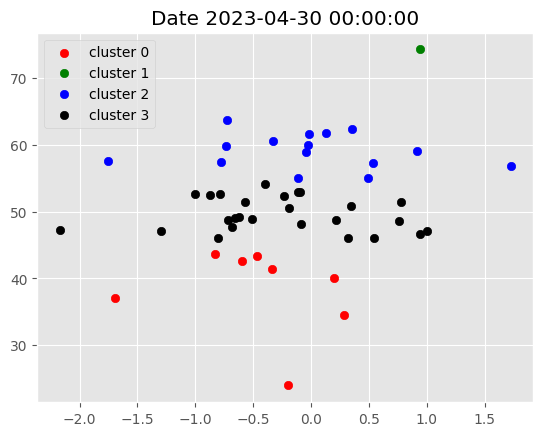

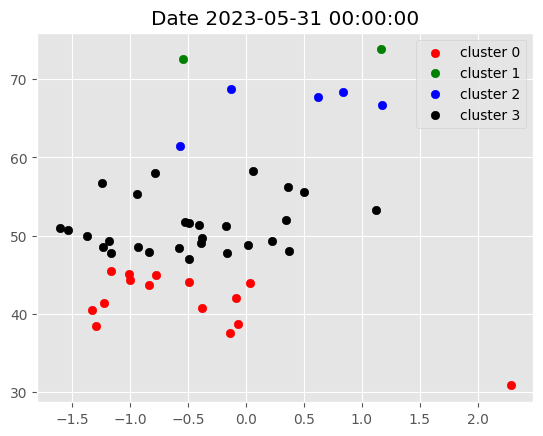

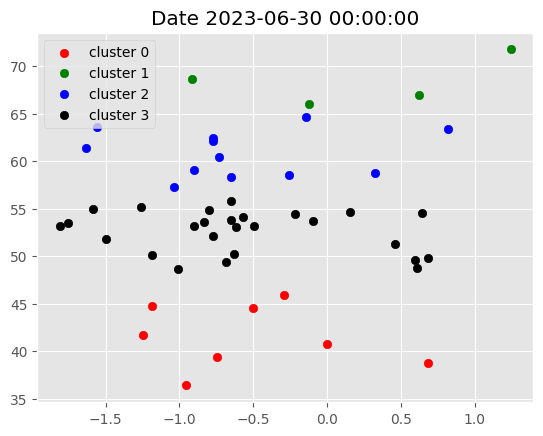

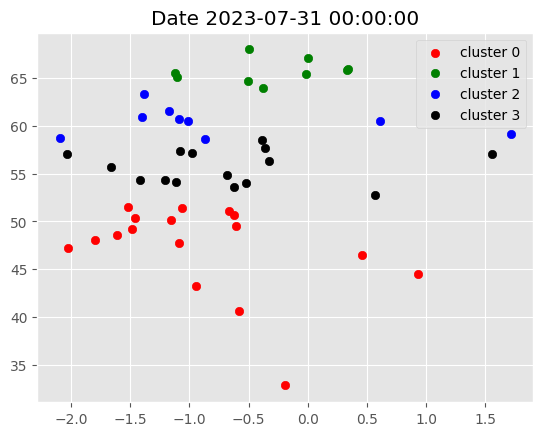

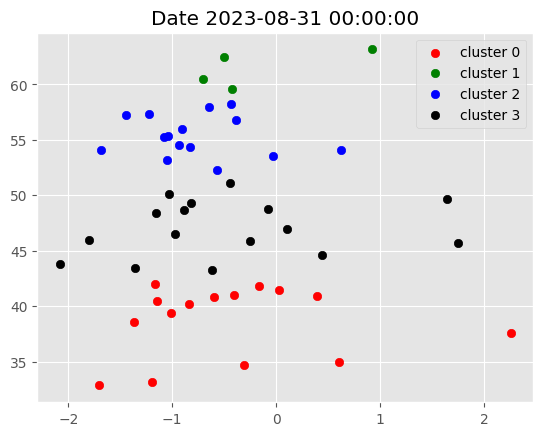

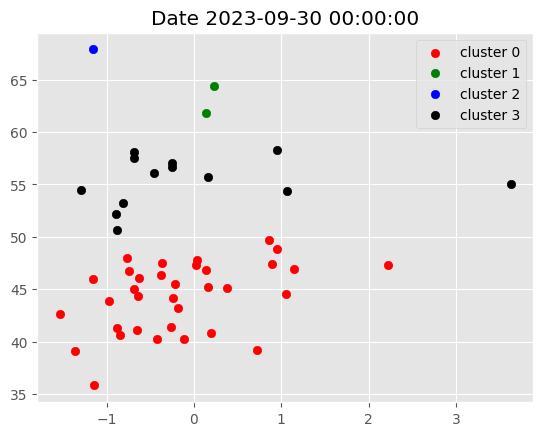

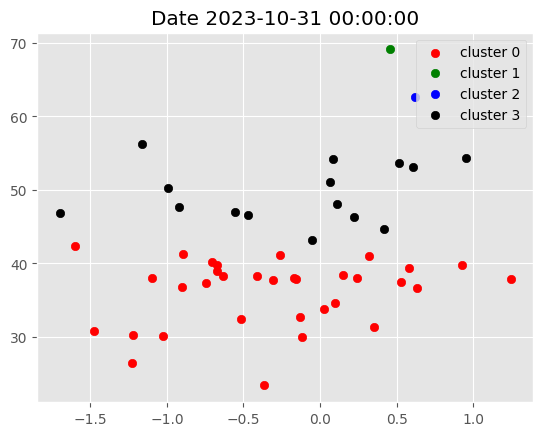

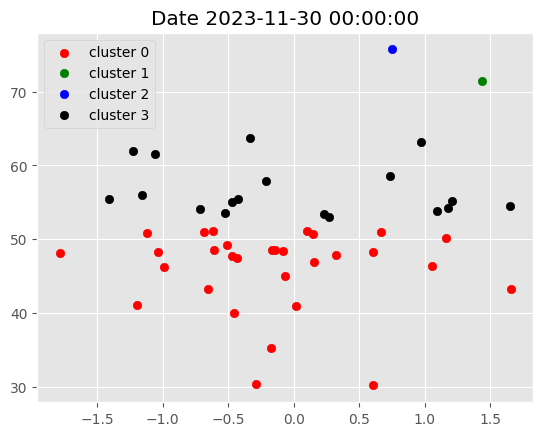

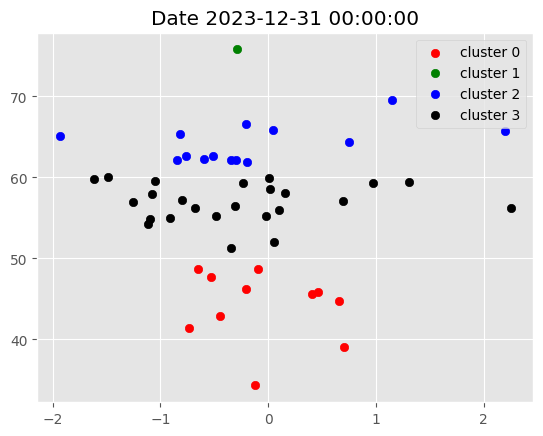

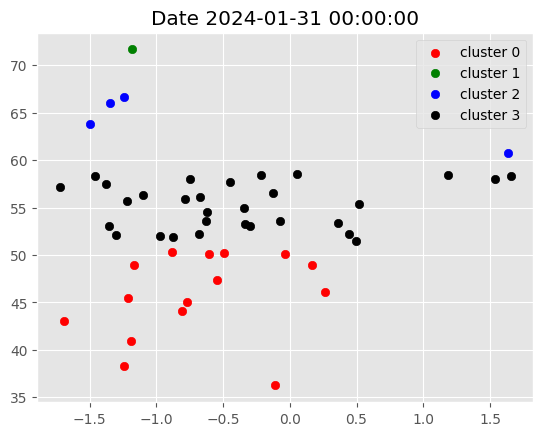

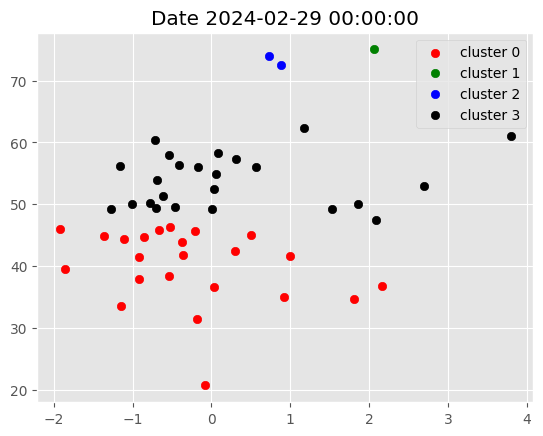

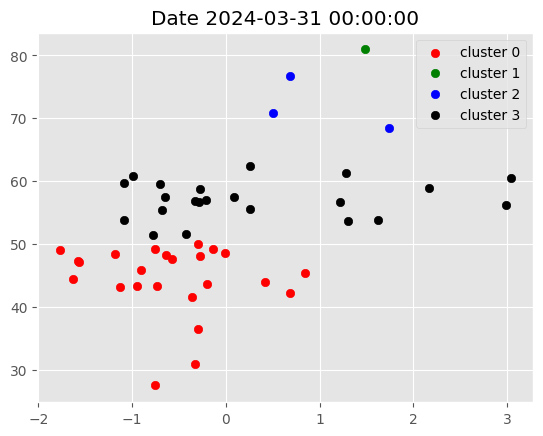

In [21]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

## 7. For each month select assests based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
* First, filter only stocks corresponding to the cluster we choose based on our hypothesis
* Momentum is persistant and the hypothesis is that stocks around 70 RSI centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluser 2

In [22]:
filtered_df = data[data['cluster']==2].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2023-05-01': ['AIA.NZ',
  'CEN.NZ',
  'CNU.NZ',
  'FPH.NZ',
  'FSF.NZ',
  'GMT.NZ',
  'GTK.NZ',
  'IFT.NZ',
  'KMD.NZ',
  'KPG.NZ',
  'MCY.NZ',
  'MEL.NZ',
  'SKT.NZ',
  'SPK.NZ',
  'THL.NZ'],
 '2023-06-01': ['ARV.NZ', 'IFT.NZ', 'OCA.NZ', 'SKO.NZ', 'SUM.NZ'],
 '2023-07-01': ['CEN.NZ',
  'FBU.NZ',
  'GMT.NZ',
  'GTK.NZ',
  'HGH.NZ',
  'IFT.NZ',
  'MEL.NZ',
  'MNW.NZ',
  'PCT.NZ',
  'SPG.NZ',
  'SUM.NZ',
  'VSL.NZ'],
 '2023-08-01': ['CEN.NZ',
  'FBU.NZ',
  'GMT.NZ',
  'HGH.NZ',
  'IPL.NZ',
  'KPG.NZ',
  'NZX.NZ',
  'RYM.NZ',
  'VGL.NZ'],
 '2023-09-01': ['ANZ.NZ',
  'CEN.NZ',
  'CHI.NZ',
  'EBO.NZ',
  'FRW.NZ',
  'HGH.NZ',
  'HLG.NZ',
  'IFT.NZ',
  'SKC.NZ',
  'SKO.NZ',
  'SKT.NZ',
  'VCT.NZ',
  'VSL.NZ',
  'WBC.NZ',
  'WHS.NZ'],
 '2023-10-01': ['SKO.NZ'],
 '2023-11-01': ['TRA.NZ'],
 '2023-12-01': ['TRA.NZ'],
 '2024-01-01': ['AIA.NZ',
  'GMT.NZ',
  'GTK.NZ',
  'IPL.NZ',
  'MEL.NZ',
  'PCT.NZ',
  'RYM.NZ',
  'SAN.NZ',
  'SCL.NZ',
  'SPG.NZ',
  'SUM.NZ',
  'THL.NZ',
  'VGL.NZ',
  'WBC.NZ'

## Define portfolio optimization function
* Using PyPortfolioOpt and EfficientFrontier optimizer, to define a function to maximize the sharpe ratio
* To optimize the weights of a given portfolio we would need to supply last 1 year prices to function
* Apply signel stock weight bounds constraints for diversification (minimum half of equally weight and maximum 10% of portfolio)

In [23]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

* download Fresh Daily Prices for Stocks

In [24]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                    start=data.index.get_level_values('date').unique()[0],
                    end=data.index.get_level_values('date').unique()[-1])

new_df 

[*********************100%%**********************]  50 of 50 completed


Price      Adj Close                                                  \
Ticker        AIA.NZ    AIR.NZ     ANZ.NZ    ARG.NZ    ARV.NZ ATM.NZ   
Date                                                                   
2023-05-01  8.702126  0.681296  24.519091  1.050394  0.997039   5.85   
2023-05-02  8.633062  0.685778  24.640057  1.045684  0.987359   5.91   
2023-05-03  8.534398  0.685778  23.923559  1.040973  0.977679   5.72   
2023-05-04  8.702126  0.685778  23.960781  1.040973  0.997039   5.75   
2023-05-05  8.633062  0.681296  23.756067  1.026843  0.987359   5.71   
...              ...       ...        ...       ...       ...    ...   
2024-03-22  8.180000  0.600000  30.570000  1.130000  1.060000   6.77   
2024-03-25  8.250000  0.595000  31.790001  1.160000  1.080000   6.74   
2024-03-26  8.200000  0.600000  31.570000  1.160000  1.090000   6.70   
2024-03-27  8.300000  0.600000  31.200001  1.140000  1.070000   6.69   
2024-03-28  8.350000  0.605000  31.900000  1.125000  1.110000   6.78   

Price                                                ...   Volume          \
Ticker        CEN.NZ    CHI.NZ    CNU.NZ     EBO.NZ  ...   SPK.NZ  SUM.NZ   
Date                                                 ...                    
2023-05-01  7.510767  1.416806  8.155225  42.643848  ...  1570508   67261   
2023-05-02  7.520347  1.397530  8.183524  42.343399  ...  1513490   88679   
2023-05-03  7.491607  1.387892  8.093906  42.450012  ...  2766121   71124   
2023-05-04  7.616148  1.387892  8.084472  42.692303  ...   708439   72077   
2023-05-05  7.558667  1.387892  8.093906  42.827988  ...  1557451   86459   
...              ...       ...       ...        ...  ...      ...     ...   
2024-03-22  8.410000  1.450000  7.730000  35.599998  ...  2815342  312585   
2024-03-25  8.340000  1.480000  7.790000  34.580002  ...  2159877  328198   
2024-03-26  8.530000  1.490000  7.620000  34.299999  ...  3143326  545768   
2024-03-27  8.530000  1.500000  7.605000  33.849998  ...  3817551  667616   
2024-03-28  8.650000  1.520000  7.690000  34.250000  ...  2375952  257763   

Price                                                                     
Ticker      THL.NZ TRA.NZ  VCT.NZ   VGL.NZ  VHP.NZ VSL.NZ WBC.NZ  WHS.NZ  
Date                                                                      
2023-05-01   82211   4174  190800  1546565  140512  12457  11337   52408  
2023-05-02  190116   6266  396265   473864  133618  19619   8395  210991  
2023-05-03   80207  20787   44962    77638  198844  14844   5429  201029  
2023-05-04   72808   8434  137544    22200  176982   1593  21541   74246  
2023-05-05   79197   8744   62216  1192036   45680  21828  26511   66597  
...            ...    ...     ...      ...     ...    ...    ...     ...  
2024-03-22   90625  32203  104492    30186  164435  14168  10455   90303  
2024-03-25   78844  13754   88126   886647  118769  13844  21060  110684  
2024-03-26  225620  15800  122716    78336  220591  56726   7576   68108  
2024-03-27   99967  31702  128423    95410  233042  21009  10579   13168  
2024-03-28   81962  92136  235747   535429  607607  22893  26741   54478  

[231 rows x 300 columns]

* Calculate daily returns for each stock which could land up in your portfolio
* Then loop over each month start, select the stocks for the month and calculate their weights for the next month
* If the mamimum sharpe ratio optimization fails for a given month, apply equally-weighted weights
* Calculate each day portfolio returns 

In [28]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df.loc[optimization_start_date:optimization_end_date, ('Adj Close')][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df


Max Sharpe Optimization failed for 2023-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-12-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2024-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2024-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2024-04-01, Continuing with Equal-Weights
'return'


,Strategy Return
date,
2023-05-02,0.005593
2023-05-03,-0.006641
2023-05-04,0.007147
2023-05-05,-0.006779
2023-05-08,0.005584
...,...
2024-03-22,-0.006729
2024-03-25,0.005794
2024-03-26,0.000194


<Axes: xlabel='date'>

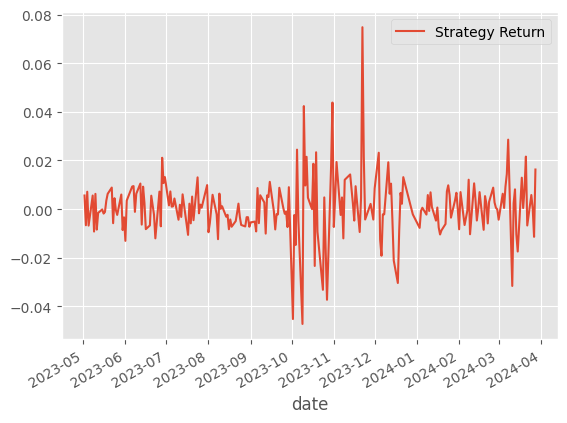

In [29]:
portfolio_df.plot()

In [26]:
# returns_dataframe = np.log(new_df['Adj Close']).diff()

# portfolio_df = pd.DataFrame()

# for start_date in fixed_dates.keys():

#     end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

#     cols = fixed_dates[start_date]

#     optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

#     optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')

#     optimization_df = new_df.loc[optimization_start_date:optimization_end_date, ('Adj Close')][cols]

#     weights = optimize_weights(prices=optimization_df,
#                            lower_bound=round(1/(len(optimization_df.columns)*2),2))
    
#     weights = pd.DataFrame(weights, index=pd.Series(0))

#     temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
#                    .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
#                           left_index=True,
#                           right_index=True)\
#                         .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

#     temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

#     temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

#     portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)


In [ ]:
# temp_df = returns_dataframe['2023-05-2':'2024-03-28']

In [ ]:
# portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

In [ ]:
# temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

# temp_df

In [ ]:
# weights = optimize_weights(prices=optimization_df,
#                           lower_bound=round(1/(len(optimization_df.columns)*2),2))
# weights
# Weights into a DF
# weights = pd.DataFrame(weights, index=pd.Series(0))

# weights

In [ ]:
# optimization_df = new_df.loc['2023-05-01':'2024-03-28', ('Adj Close')][fixed_dates['2023-05-01']]

In [ ]:
# optimization_df

In [ ]:
# fixed_dates['2023-05-01']

In [ ]:
# optimization_df

In [ ]:
# round(1/(len(optimization_df.columns)*2),2)

In [ ]:
# index_names = df.index.names
# column_names = df.columns.names

# print("Index Names:", index_names)
# print("Column Names:", column_names)

# Assuming your DataFrame is named 'df'
# ticker = 'AIR.NZ'
# start_date = '2023-05-01'
# end_date = '2023-05-02'

# adj_close_data = new_df.loc[start_date:end_date, ('Adj Close')]
# print(adj_close_data)

# from IPython.display import display, HTML
# display(HTML(returns_dataframe.to_html()))